In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.discriminative_models import LogisticRegression
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.optimizers.ppcef import PPCEF

In [3]:
def plot_model_distribution(model, median_prob=None, disc_model=None):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 12)

    xline = torch.linspace(-1.5, 2.5, 200)
    yline = torch.linspace(-0.75, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        zgrid0 = model(xyinput, torch.zeros(40000, 1)).exp().reshape(200, 200)
        zgrid1 = model(xyinput, torch.ones(40000, 1)).exp().reshape(200, 200)

    zgrid0 = zgrid0.numpy()
    zgrid1 = zgrid1.numpy()

    if median_prob is not None:
        median_prob = np.exp(median_prob)
        cs1_mp = ax.contourf(
            xgrid.numpy(),
            ygrid.numpy(),
            zgrid1,
            levels=[median_prob, median_prob + 10.00],
            alpha=0.1,
            colors="#DC143C",
        )

    cs0 = ax.contour(
        xgrid.numpy(),
        ygrid.numpy(),
        zgrid0,
        levels=10,
        cmap="Greys",
        linewidths=0.4,
        antialiased=True,
    )
    cs1 = ax.contour(
        xgrid.numpy(),
        ygrid.numpy(),
        zgrid1,
        levels=10,
        cmap="Oranges",
        linewidths=0.4,
        antialiased=True,
    )
    return ax


def plot_unconditional_model_distribution(model, median_prob=None, disc_model=None):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(20, 12)

    xline = torch.linspace(-1.5, 2.5, 200)
    yline = torch.linspace(-0.75, 1.25, 200)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    zgrid = model(xyinput).exp().reshape(200, 200).detach().numpy()

    cs = ax.contour(
        xgrid.numpy(),
        ygrid.numpy(),
        zgrid,
        levels=10,
        cmap="Greys",
        linewidths=0.4,
        antialiased=True,
    )
    return ax

In [4]:
dataset = MoonsDataset(file_path="../data/moons.csv")

disc_model = LogisticRegression(input_size=2, target_size=1)
disc_model.load("../models/MoonsDataset/disc_model_LogisticRegression.pt")

flow = MaskedAutoregressiveFlow(features=2, hidden_features=4, context_features=1)
flow.load("../models/MoonsDataset/gen_model_MaskedAutoregressiveFlow.pt")

cf = PPCEF(
    gen_model=flow,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
    neptune_run=None,
)

In [5]:
median_prob = cf.calculate_median_log_prob(
    dataset.train_dataloader(batch_size=64, shuffle=False)
)
median_prob

-0.13134873

We want to figure out the subset of training dataset that is properly classified as desired class and in the same time, it's probabilistically plausible.

In [6]:
desired_class = 1
train_log_probs = cf.gen_model.predict_log_probs(dataset.X_train).T.detach().numpy()
train_prediction = cf.disc_model.predict(dataset.X_train)

In [7]:
dataset.X_train.shape, train_log_probs.shape, train_prediction.shape

((921, 2), (921, 2), (921,))

In [8]:
dataset.X_train.shape

(921, 2)

In [9]:
dataset.X_train[train_prediction == desired_class].shape

(456, 2)

In [10]:
condition = np.logical_and(
    train_prediction == desired_class, train_log_probs[:, desired_class] > median_prob
)

In [11]:
condition.shape

(921,)

In [12]:
conditional_dataset = dataset.X_train[condition]

In [13]:
conditional_dataset.shape

(218, 2)

And now we plot it agains the probabilistic distribution, classification region, probabilistic plausability region, and the whole dataset.

/opt/homebrew/anaconda3/envs/counterfactuals/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


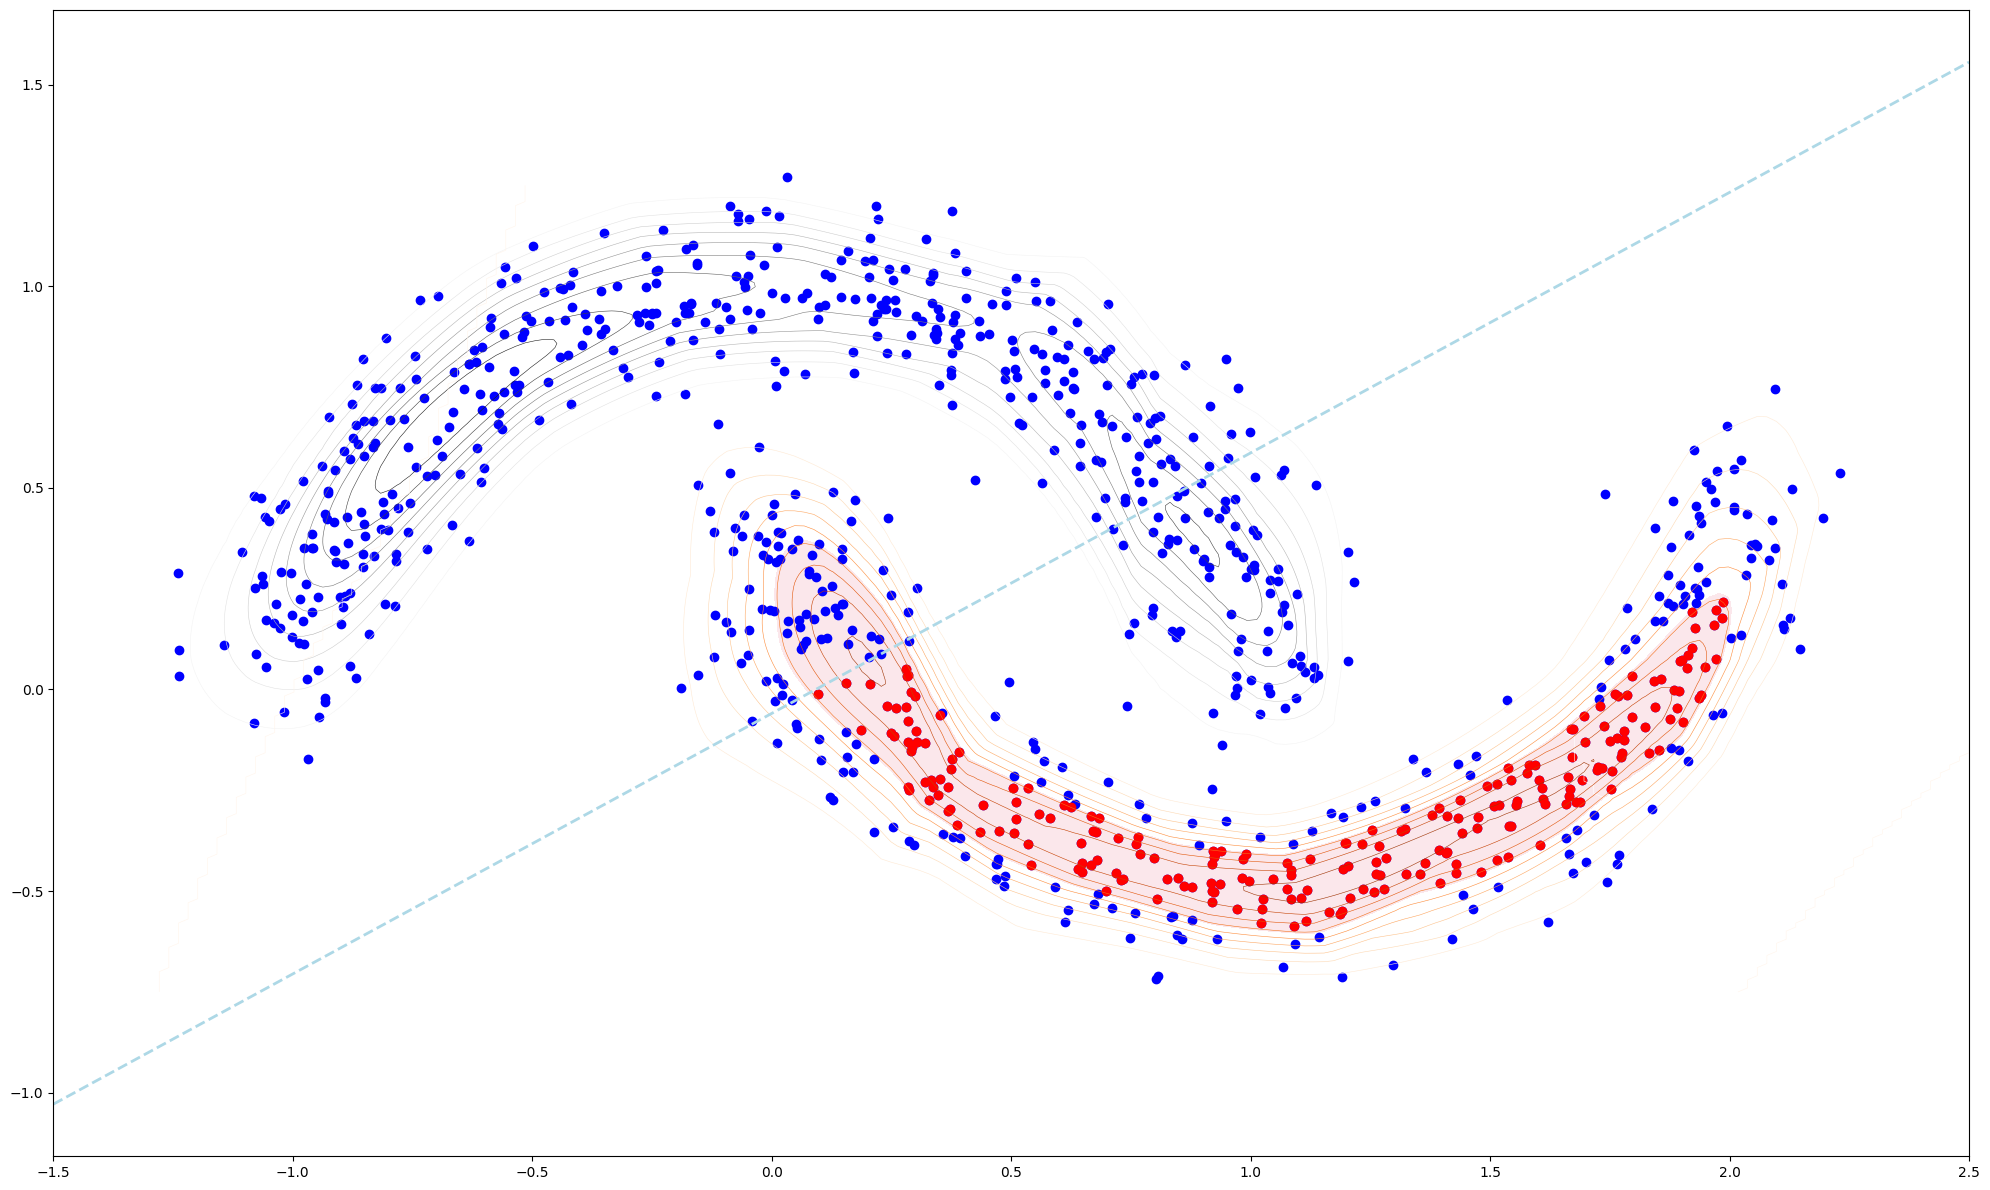

In [14]:
## Variables
filled_markers = (".", "o", "v", "8", "s", "p", "*", "h", "H", "D", "d", "P", "X")

## Distribution Plot
ax = plot_model_distribution(cf.gen_model, median_prob, disc_model)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b / w2
m = -w1 / w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m * xd + c
plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")
# plt.axis("off")

plt.scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], color="b")
plt.scatter(conditional_dataset[:, 0], conditional_dataset[:, 1], color="r")

## Save Figure
plt.tight_layout()
# plt.savefig('moons.pdf')

## Train Flow Now!

The idea is to train unconditional normalizing flow to sample from this area.

In [15]:
maf = MaskedAutoregressiveFlow(features=2, hidden_features=4)

In [16]:
X_train_cond, X_test_cond = train_test_split(
    conditional_dataset, test_size=0.2, random_state=42
)

# Convert the numpy arrays to PyTorch tensors
X_train_cond_tensor = torch.tensor(X_train_cond, dtype=torch.float32)
X_test_cond_tensor = torch.tensor(X_test_cond, dtype=torch.float32)

# Create TensorDatasets for both training and testing
train_dataset = TensorDataset(X_train_cond_tensor)
test_dataset = TensorDataset(X_test_cond_tensor)

# Create DataLoaders for both training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
maf.fit(train_loader, test_loader, num_epochs=1000)

Epoch 999, Train: -0.6091, test: -0.7026: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.17it/s]


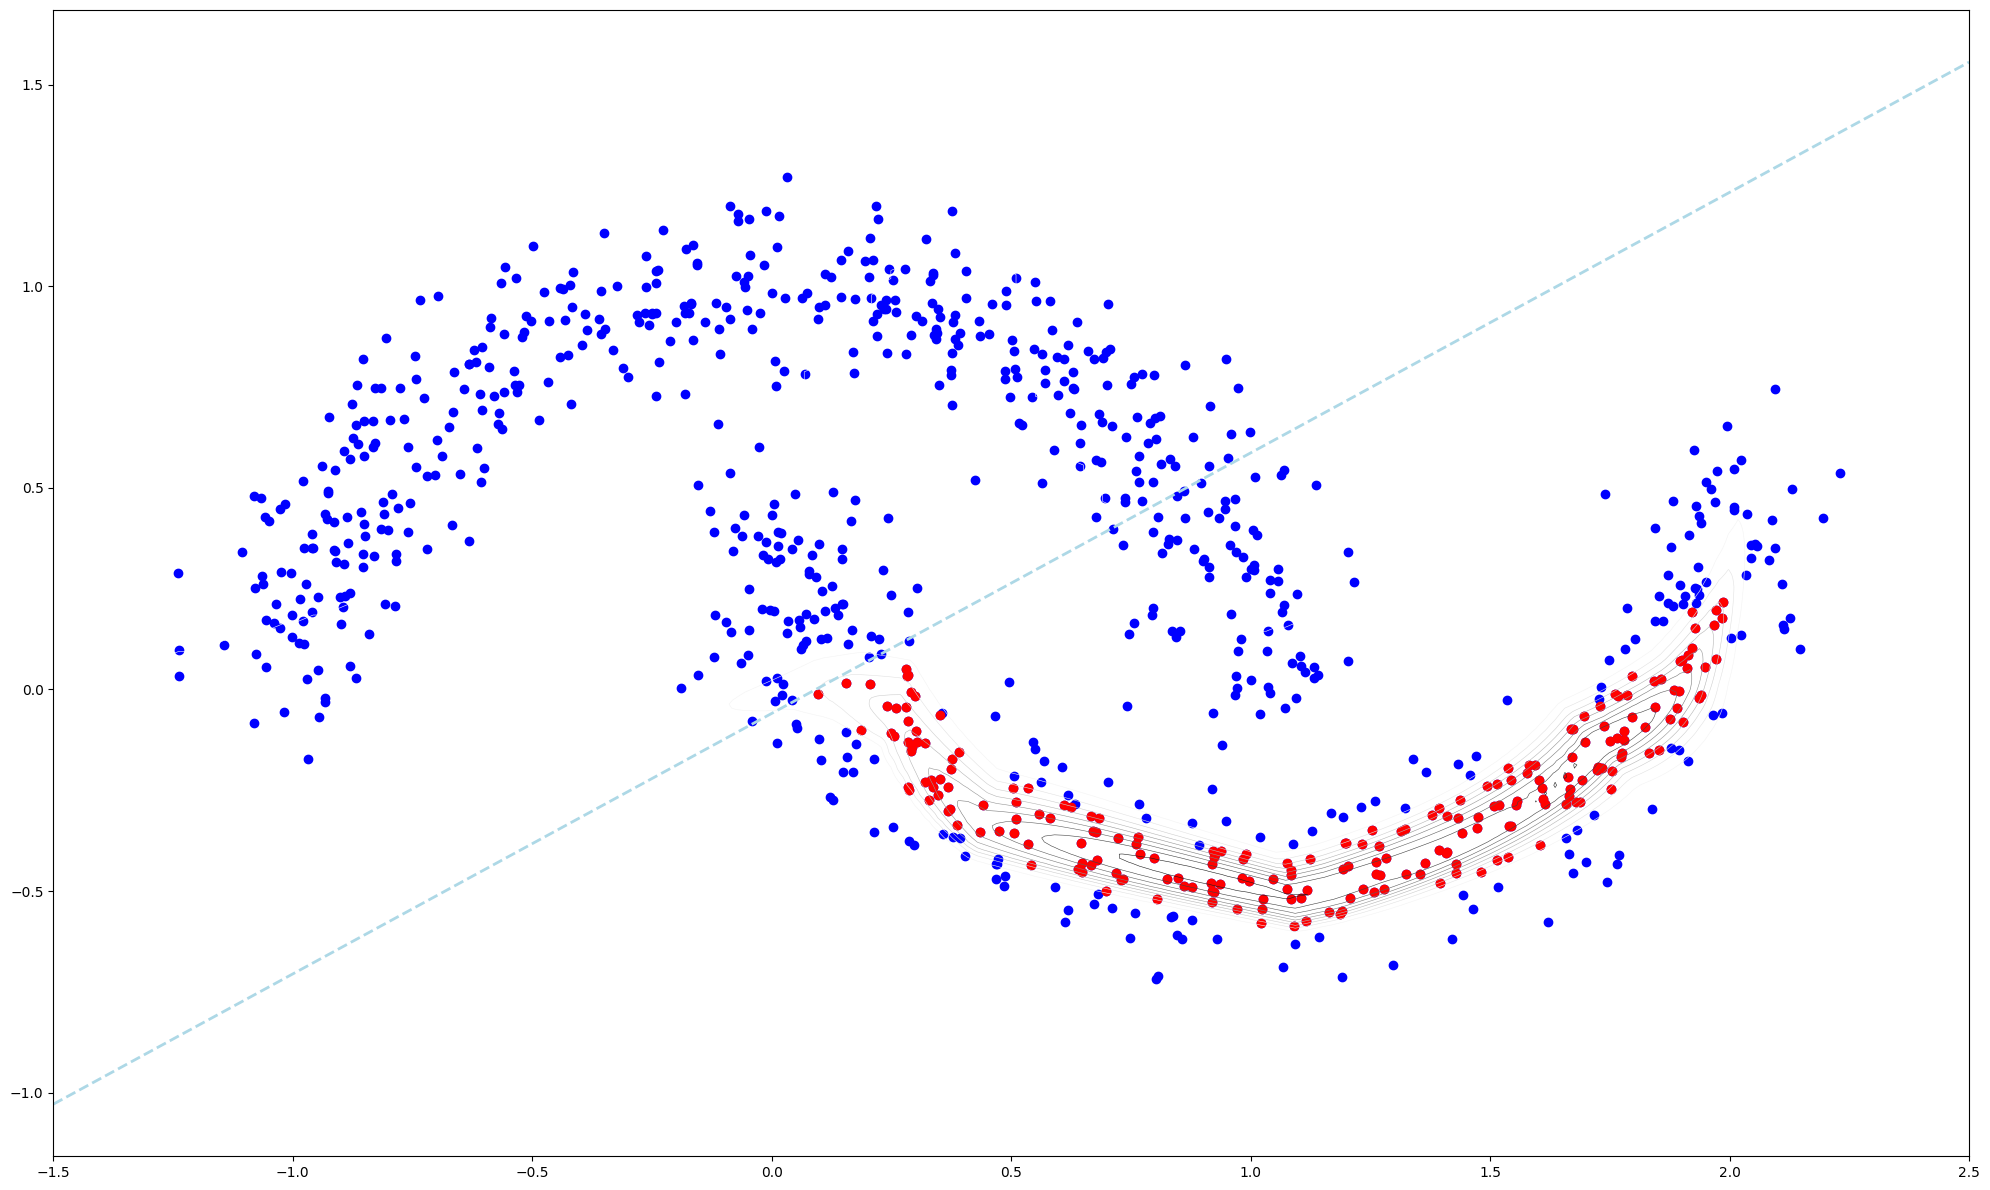

In [18]:
ax = plot_unconditional_model_distribution(maf)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b / w2
m = -w1 / w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m * xd + c
plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")
# plt.axis("off")

plt.scatter(dataset.X_train[:, 0], dataset.X_train[:, 1], color="b")
plt.scatter(conditional_dataset[:, 0], conditional_dataset[:, 1], color="r")

## Save Figure
plt.tight_layout()
# plt.savefig('moons.pdf')

### Let's sample!

In [19]:
samples = maf.model.sample(20)

samples_predictions = disc_model(samples)

samples = samples.detach().numpy()

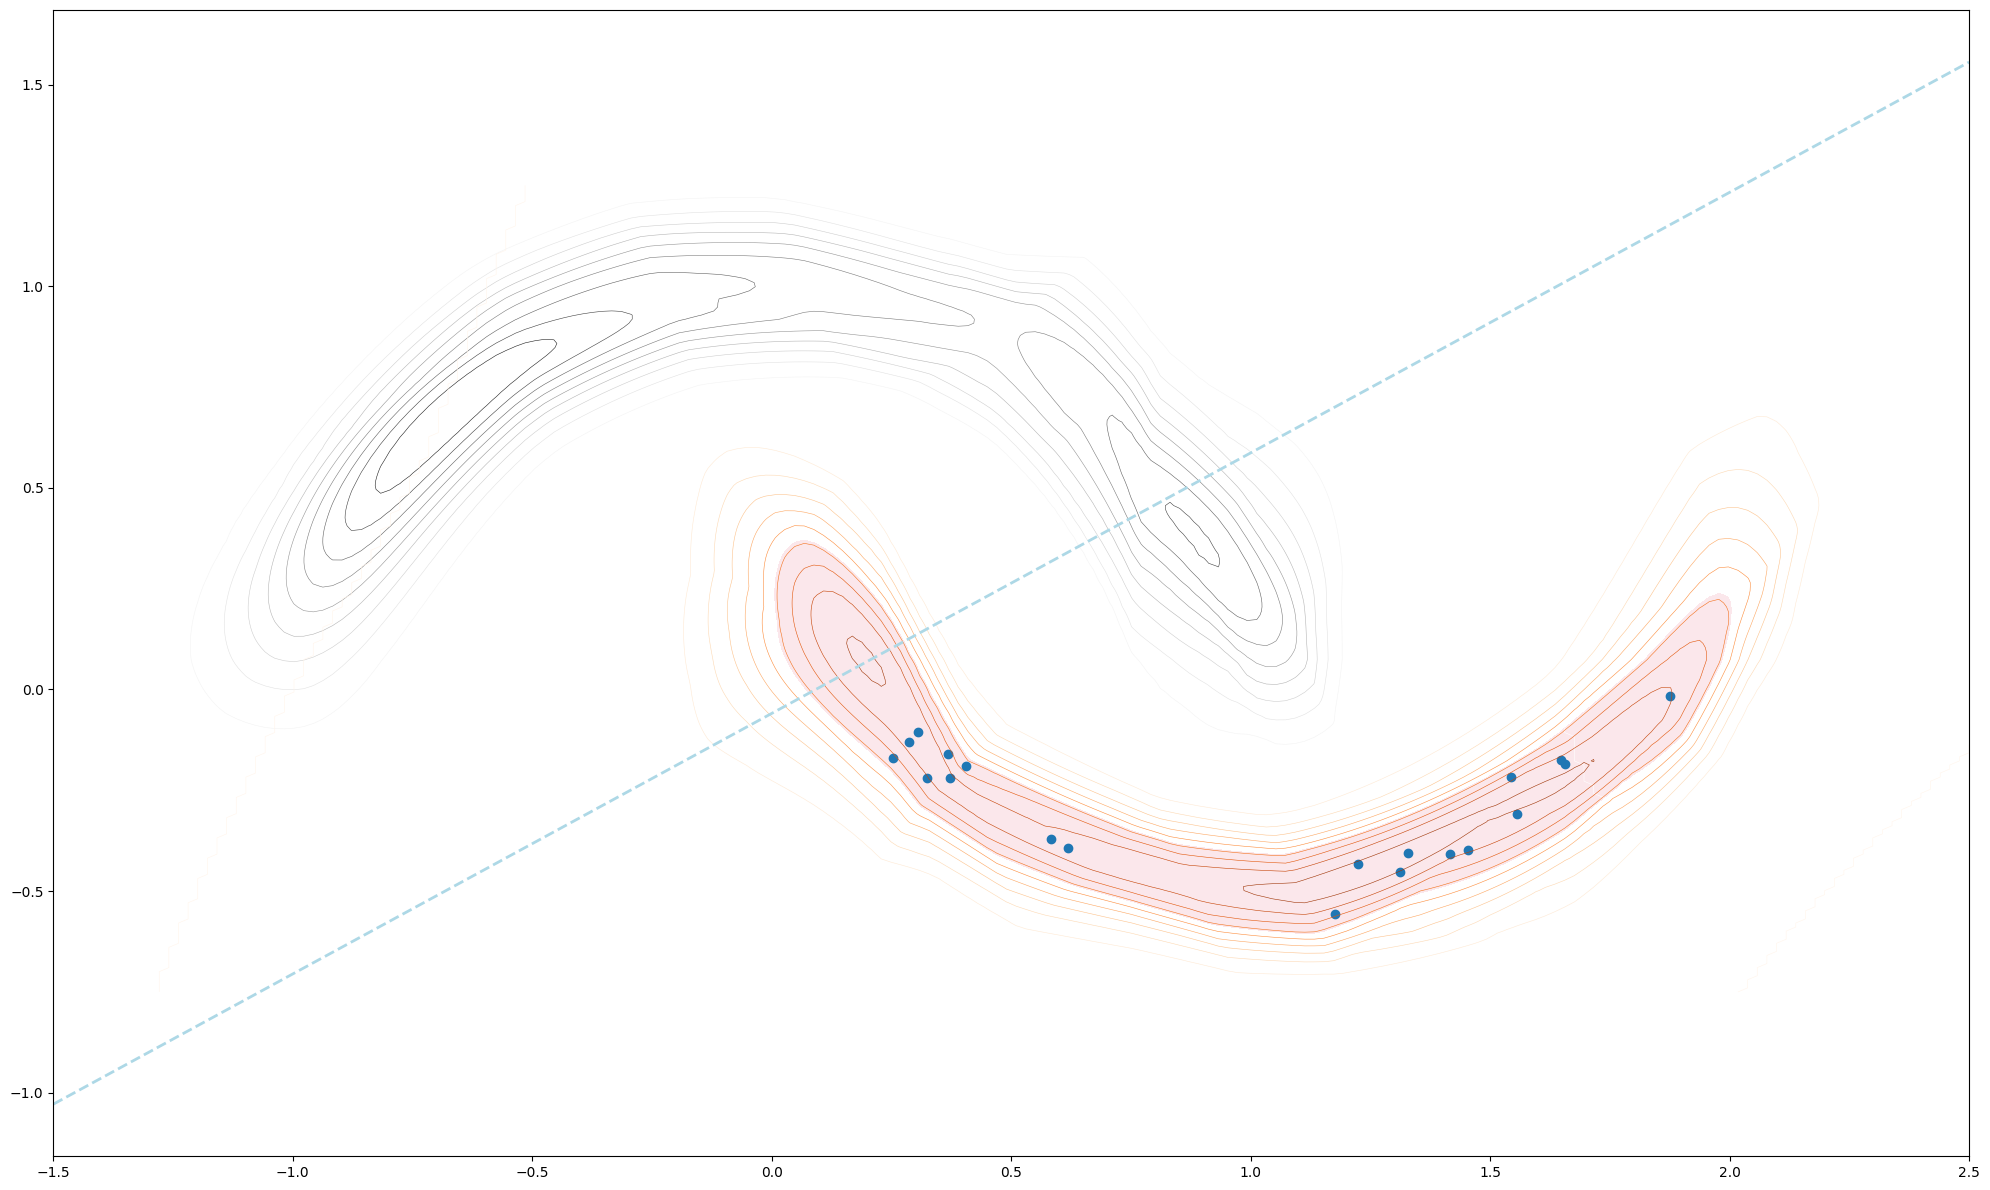

In [20]:
## Distribution Plot
ax = plot_model_distribution(cf.gen_model, median_prob, disc_model)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b / w2
m = -w1 / w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m * xd + c
plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")

plt.scatter(samples[:, 0], samples[:, 1])

## Save Figure
plt.tight_layout()
# plt.savefig('moons.pdf')

In this example we see that all of the generated observations are in the desired area, but just to make sure it will always be that way, we do some filtering.

In [21]:
x_origin = np.array([[0.90, 0.50]])

In [22]:
samples_log_probs = cf.gen_model.predict_log_probs(samples).T.detach().numpy()
samples_prediction = cf.disc_model.predict(samples)

samples_condition = np.logical_and(
    samples_prediction == desired_class,
    samples_log_probs[:, desired_class] > median_prob,
)
samples_final = samples[samples_condition]

### The MAGIC!

Here we do the magic of final samples selection, in that case, we calculate the L1 distance and select TOP5 observations.

There is obviously room for the improvement and sophistication.

In [23]:
samples_norms = np.linalg.norm(x_origin - samples_final, axis=1)
samples_order = np.argsort(samples_norms)

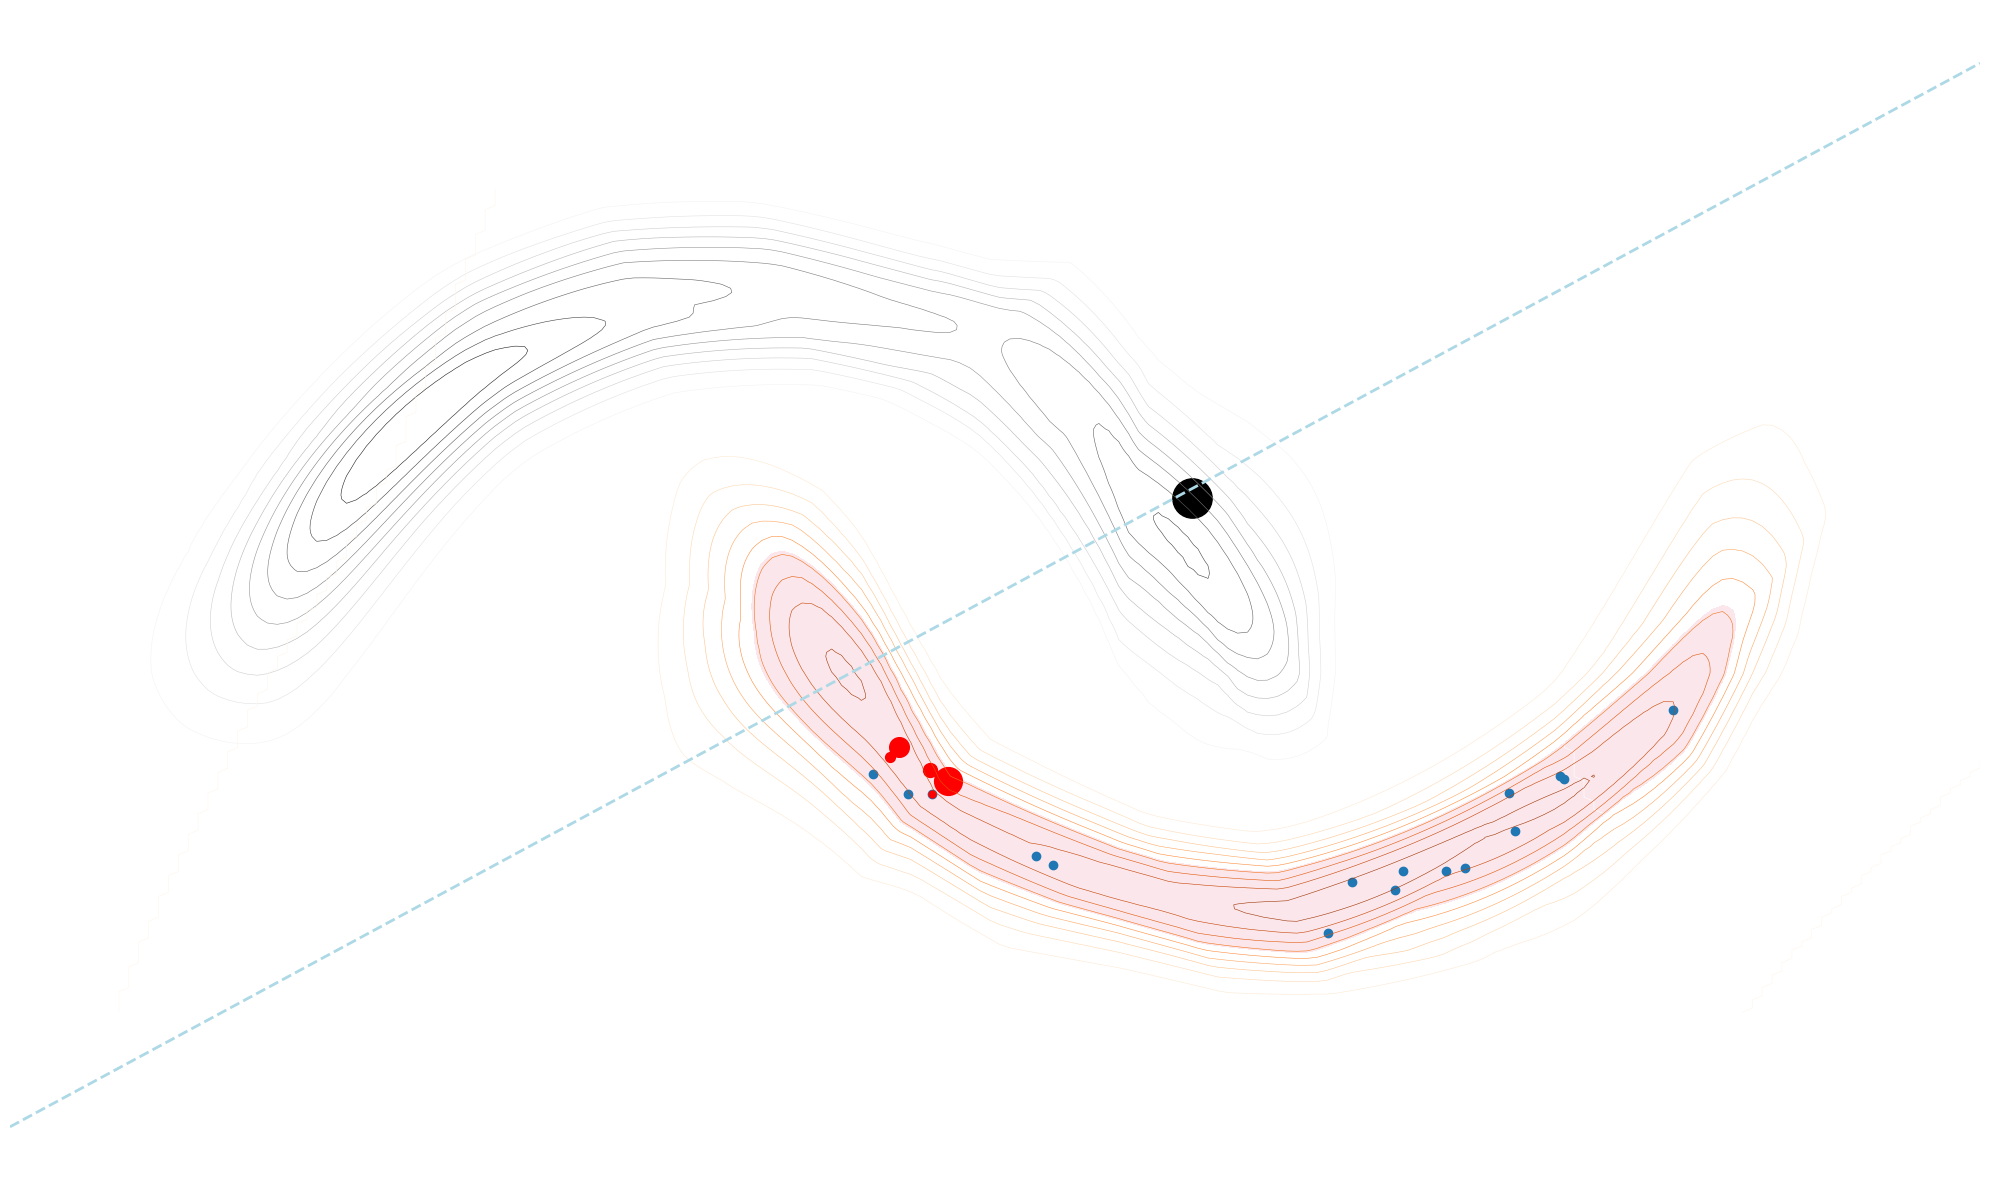

In [24]:
## Distribution Plot
ax = plot_model_distribution(cf.gen_model, median_prob, cf.disc_model)

## Classifier Line
w1, w2 = list(disc_model.parameters())[0].detach().cpu().numpy()[0]
b = list(disc_model.parameters())[1].detach().cpu().numpy().item()
c = -b / w2
m = -w1 / w2
xmin, xmax = -1.5, 2.5
ymin, ymax = -1.5, 2.5
xd = np.array([xmin, xmax])
yd = m * xd + c
plt.plot(xd, yd, "#ADD8E6", lw=2.0, ls="dashed")
plt.axis("off")

plt.scatter(x_origin[:, 0], x_origin[:, 1], c="k", s=800)

plt.scatter(samples[:, 0], samples[:, 1])

plt.scatter(samples[samples_order[0], 0], samples[samples_order[0], 1], c="r", s=400)
plt.scatter(samples[samples_order[1], 0], samples[samples_order[1], 1], c="r", s=200)
plt.scatter(samples[samples_order[2], 0], samples[samples_order[2], 1], c="r", s=100)
plt.scatter(samples[samples_order[3], 0], samples[samples_order[3], 1], c="r", s=50)
plt.scatter(samples[samples_order[4], 0], samples[samples_order[4], 1], c="r", s=25)

## Save Figure
plt.tight_layout()
# plt.savefig('moons.pdf')